In [25]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

Use hourly demand to predict hourly emissions

**Load data**

In [26]:
# CA hourly CO2 emissions and demand

df = pd.read_csv('data/emissions_demand.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

print(f"shape: {df.shape}")
df.head()

shape: (6168, 3)


,date,demand,emissions
0,20221127T23Z,23637,84405
1,20221127T22Z,23599,87295
2,20221127T21Z,23323,88500
3,20221127T20Z,23718,88878
4,20221127T19Z,25038,90162


**Correlation**

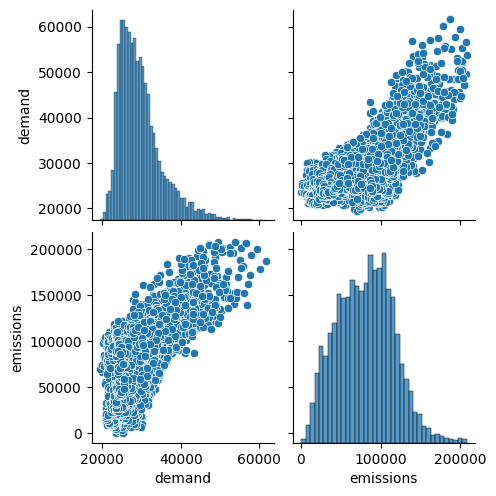

In [27]:
ed = df[['demand','emissions']]

sns.pairplot(ed, kind="scatter")
plt.show()

In [31]:
corrcoef = np.corrcoef(df['demand'], df['emissions'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['demand'], df['emissions']).pvalue
print(f'p-value: {p_value}')

Correlation coefficient: 0.7091568869118104
p-value: 0.0


**Model**

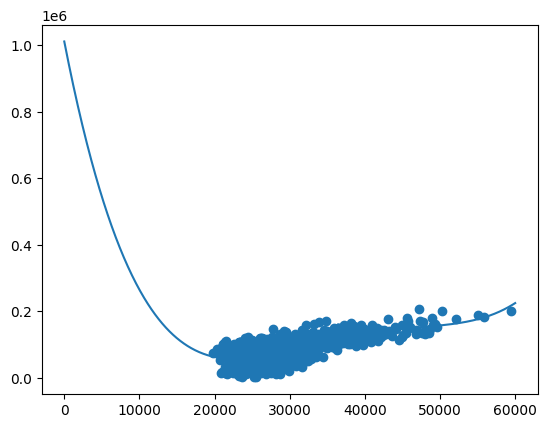

In [10]:
X = df["demand"]
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

mymodel = np.poly1d(np.polyfit(X_train, y_train, 4))

myline = np.linspace(0, 60000, 1000)

plt.scatter(X_train, y_train)
plt.plot(myline, mymodel(myline))
plt.show()

In [11]:
print(f'Training data score: {r2_score(y_train, mymodel(X_train))}')
print(f'Testing data score: {r2_score(y_test, mymodel(X_test))}')

Training data score: 0.5067819960113743
Testing data score: 0.5161641040691121


**Model**

In [9]:
X = df.drop(columns=["date","emissions"])
y = df["emissions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

distribution = {
        'n_estimators': [5,10,20,30,50,100,200,300,500] ,
        'max_features': ['auto', 'sqrt','log2']
       }

forest = RandomForestRegressor()
random_rf = RandomizedSearchCV(estimator = forest, param_distributions = distribution, n_iter = 10)                
random_rf.fit(X_train,  y_train)

print(f'Training data score: {random_rf.score(X_train,  y_train)}')
print(f'Testing data score: {random_rf.score(X_test, y_test)}')


Training data score: 0.8607750787911672
Testing data score: 0.3086480499120956
